In [ ]:
import  confusionTable_extractFeature as CTF

In [1]:
import math

In [2]:
import sys

In [3]:
from multiprocessing import Pool

In [4]:
import pickle
import numpy as np
from sklearn import svm

In [5]:
from sklearn.preprocessing import Normalizer, StandardScaler

In [6]:
from sklearn.naive_bayes import GaussianNB

In [7]:
from collections import defaultdict
import matplotlib.pyplot as plt

In [10]:
with open('/home/kiwi/udn_data/training_confusion/ch_5401.txt', 'r', encoding='utf8') as fp:                    
    CH5400 = set(i.strip() for i in fp.readlines())

In [11]:

POS = 1
NEG = -1
UNK = 2


In [12]:
PROCESSCNT = 6
MULTIPROCESS = True
PRE = False
NB = False

In [13]:
def fCombine(score, log):
    # 0.89/0.86    
#     tmp = log[:-2]
#     tmp.append(score-log[-3]*9-log[-2])
    
    
    # 0.90/0.89
#     tmp = log[:-2]

    # 0.90/0.89
#     tmp = log[:-2]

    # 0.99/0.99
#     tmp = log[:-2]
#     tmp.append(score)

    # 0.89/0.86
#     tmp = log[:-2]
#     s = sum(log[:-2])
#     tmp.append(s)

    # 0.99/0.99
    tmp = log[:-2]
    s = score - log[-3]*9
    tmp.append(s)
    
    
    return tmp

In [14]:
def extract(bigDict):
    '''Extract (feature/label) from filename
    Args:
        bigDict (nested dict): the dict of feature (*.pkl) from confusionTable_extractFeature
    Return:
        train_feature (np.array): feature array
        train_label (np.array): the label of feature 
            (1 for positive, 2 for negative )
    '''
    
    # Initial 
    label = list()
    feature = list()

    for error_ch, (cands_val) in bigDict.items():
        if error_ch not in CH5400:
            continue
        
        
        # two situation for error: (error-pair) or (higher-score)
        for cand, (score, log) in cands_val.items():  
            if cand not in CH5400:
                continue
            
            
            
            feature.append(fCombine(score,log))
            if log[-2] != 0:
                label.append(POS)
            else:
                label.append(UNK)
    
    # Combine
    train_feature = np.asarray(feature, dtype='float')            
    tmp_label = np.asarray(label, dtype='int')
    pos = np.where(tmp_label == POS )[0]
    neg = np.where(tmp_label == UNK )[0]
    train_label = {POS:pos, UNK:neg}        

    print('The number of sample = {}'.format(train_feature.shape))
    print('Positive case (candidate) = {}'.format(len(train_label[POS])))
    print('Negative case (uncandidate) = {}'.format(len(train_label[UNK])))
    
    return (train_feature, train_label)

In [15]:
def preprocess(data, method):
    '''Preprocessing of feature
    Args:
        data (np.array): feature 
        method (str): 'normal'-normalization // 'standard'-standardization
    Return:
        new_data (np.array): after preprocessing 
        pre (scikit.preprocess): transform model for feature     
    '''
    if PRE:    
        if method == 'normal':
            pre = Normalizer().fit(data)
            new_data = pre.transform(data)
        elif method == 'standard':
            pre = Normalizer().fit(data)
            new_data = pre.transform(data)
        else:
            print('Unknown method')
            sys.exit(0)
        
        return (new_data, pre)
    else:
        return (data, [])

In [16]:
def rnBatch(para):
    (idx, feature, nbf) = para
    
    if nbf.predict(feature.reshape(1,-1)) == UNK:
        return idx
    else:
        return -1

In [17]:
def rnSelect(feature, label):
    
    if NB:
        
        nbf_idx = np.concatenate((label[POS],label[UNK]))
        nbf_label = np.concatenate(
            (np.full(len(label[POS]), POS, dtype=int)
             , np.full(len(label[UNK]), UNK, dtype=int)))
        nbf_feature = feature[nbf_idx]
        nbf = GaussianNB().fit(nbf_feature, nbf_label)

        print('Prepare chunk')
        chunk = [(idx, feature[idx], nbf) for idx in label[UNK]]

        print('Start RN step select')    
        if MULTIPROCESS:
            with Pool(processes=PROCESSCNT) as pool:
                rn_neg = pool.map(rnBatch, chunk)
        else:
            rn_neg = [rnBatch(c) for c in chunk]


        label[NEG] = np.where(np.asarray(rn_neg) != -1)[0]


        print('Label[POS]: {}'.format(len(label[POS])))
        print('Label[NEG]: {}'.format(len(label[NEG])))
        print('Remove Unknown {} samples'.format(len(label[UNK])-len(label[NEG])))
    
    else:
        label[NEG] = label[UNK]
    
    return label

In [18]:
def train_svm(feature, label, train_cnt, cost= 0, test_cnt=0, cross_validation=False, g=1/11):
    '''Train SVM model from feature
    Args:
        feature (np.array): feature array
        label (np.array): the label of feature 
        train_cnt (int): the number of training samples 
        test_cnt (int): (default=samples-train_cnt) the number of testing samples
    Return:
        xxx    
    '''
    
    assert train_cnt < len(label[POS]), 'Train count must less than positive samples'
    
    # If test_cnt not declare, use all the remain set as test set    
    if train_cnt==0:
        assert False, 'sample count cannot be zero'
        
    if test_cnt==0:
        test_cnt = len(label[POS]) - train_cnt
        
    # Picke feature/label to train & test set    
    np.random.shuffle(label[POS])
    np.random.shuffle(label[NEG])

    train_idx = np.concatenate(
        (label[POS][:train_cnt],
         label[NEG][:train_cnt]))
    train_label = np.concatenate(
        (np.full(train_cnt, POS, dtype=int), np.full(train_cnt, NEG, dtype=int)))
    train_feature = feature[train_idx]

    test_idx = np.concatenate(
        (label[POS][train_cnt:train_cnt+test_cnt], 
         label[NEG][train_cnt:train_cnt+test_cnt]))
    test_label = np.concatenate(
        (np.full(test_cnt, POS, dtype=int), np.full(test_cnt, NEG, dtype=int)))
    test_feature = feature[test_idx]

    # Training 
    clf = svm.SVC(kernel='rbf',C=cost,gamma=g, probability=True)
    clf.fit(train_feature,train_label)
    
    # Testing 
    accuracy = clf.score(test_feature, test_label)
    pos_acc = clf.score(test_feature[:test_cnt], test_label[:test_cnt])
    print('Accuracy ({}/{}): {}'.format(test_cnt, len(test_label), accuracy))
    print('Positive Accuracy ({}): {}'.format(test_cnt, pos_acc))
    
#     output = [accuracy, train_cnt, test_cnt*2]
#     return output
    return clf

In [19]:
def create_batch(chunk):
    global clf
    global pre_filter
    global threshold
#     global confusion
#     (cand, threshold) = chunk
    
    (ch, cands) = chunk
    
    if ch not in CH5400:
        return []
    
    
    
    f_batch = []
    for ca, (score,log) in cands.items(): 
        if ca not in CH5400:
            continue        
        
        if log[-2] != 0:
            f_batch.append((ca, 1))   
        else:
            t = fCombine(score,log)
            if PRE:
                
                tmp = pre_filter.transform(np.asarray(t).reshape(1,-1))
            else:
                tmp = np.asarray(t).reshape(1,-1)
            
            f = clf.predict_proba(tmp).tolist()[0]            
                               
            if f[1] > f[0] and f[1] > threshold[0]:
                f_batch.append((ca, f[1]))

    if len(f_batch) > 0:
        f_sorted = sorted(f_batch, key=lambda x:x[1], reverse=True)[:threshold[1]]
        f_dict = {ca:s for ca, s in f_sorted}

        return (ch, f_dict)
    else:
        return []


In [20]:
# def create_old(clf, bigDict, pre_filter, threshold):
def create(bigDict):
    
    '''Construct basic NCM
    
    '''
#     global clf
#     global pre_filter
    
    confusion = dict()
    c_t, c_tf, sk = 0,0,0
    
    tt = list(bigDict.items())
    
    if MULTIPROCESS:
        with Pool(processes=PROCESSCNT) as pool:
            r = pool.map(create_batch, tt)
        confusion = {c[0]:c[1] for c in r if len(c)>0}
    else:
        for chunk in tt:
            batch = create_batch(chunk)
            if len(batch)>0:
                confusion[batch[0]] = batch[1] 
            
    return confusion

In [21]:
def info(confusion):
    '''Get basic information about NCM 
    
    '''
    total_error = len(confusion)
    cands = [(ch, len(cand)) for (ch, cand) in 
        sorted(confusion.items(), key= lambda x:len(x[1]), reverse=True)]

    sum_cands = sum(cnt for _, cnt in cands)
    max_cands = max(cnt for _, cnt in cands)
    min_cands = min(cnt for _, cnt in cands)
    mean_cands = sum_cands/total_error
    
    if total_error%2 == 0:
        mid_cands = cands[total_error//2]
    else:
        mid_cands = cands[(total_error+1)//2]
    
    print('Total_error: {}\nSum_cands: {}'.format(total_error, sum_cands))
    print('Max_cands: {}\nMin_cands: {}'.format(max_cands, min_cands))
    print('Mean_cands: {:.2f}\nMid_cands: {}'.format(mean_cands, mid_cands))
    print('Top 20 cands:\n {}'.format(cands[:20]))
    
    plt.plot([cnt for _, cnt in cands])
    plt.xlabel('index')
    plt.ylabel('candidates number')
    fig = plt.gcf()
    plt.show()
    fig.savefig('./confusionTable/confu_info.png',dpi=100)

In [22]:
def outputPKL(confusion, ncm_correct, pkl_file):
    '''Assign local probability and output to NCM file
    '''
    output = defaultdict(dict)
    
    for ch, cands in confusion.items():
        total_cand_val = sum(cands.values())*(1-ncm_correct) + ncm_correct
        output[ch] = {ca:(p*(1-ncm_correct))/total_cand_val for ca,p in cands.items()}
        output[ch][ch] = ncm_correct/total_cand_val        
    
    with open(pkl_file, 'wb') as fp:
        pickle.dump(output, fp)
    
    return output

In [23]:
if __name__ == '__main__':
    feature_file = './confusionTable/feature.pkl'
    output_file = './confusionTable/confu_{}.pkl'.format
    ncm_correct = 0.95
        
    with open(feature_file, 'rb') as fp:
        dataset = pickle.load(fp)
    
    

In [24]:
test_val = list(range(1000,8000,1000))
print(test_val)

[1000, 2000, 3000, 4000, 5000, 6000, 7000]


In [25]:
feature,label = extract(dataset)

The number of sample = (1561823, 11)
Positive case (candidate) = 8400
Negative case (uncandidate) = 1553423


In [28]:
PROCESSCNT = 6
MULTIPROCESS = True
PRE = False
NB = False

choose_train = 4

In [29]:
print('PRE\t{}\nNB\t{}'.format(PRE,NB))

PRE	False
NB	False


In [221]:
# cc = 200
# gg = 0.045
for cc in [0.05,0.1,0.5,1,2,5,10,20,50,100,200,400,800,1600]:
    for gg in [0.01125, 0.0225, 0.045, 0.09, 0.18, 0.36, 0.72, 1.44]:
# if True:
        (new_feature, pre_filter) = preprocess(feature, 'normal')
        label = rnSelect(new_feature, label)
        print(test_val[choose_train], cc, gg)
        for i in range(2):
            clf = train_svm(new_feature, label, test_val[choose_train], cost=cc, g=gg)

5000 0.05 0.01125


KeyboardInterrupt: 

In [231]:
# for cc in [0.05,0.1,0.5,1,2,5,10,20,50,100]:
# for gg in [0.01125, 0.0225, 0.045, 0.09, 0.18, 0.36, 0.72, 1.44]:

(new_feature, pre_filter) = preprocess(feature, 'normal')
label = rnSelect(new_feature, label)
print(test_val[choose_train], 0.0225)
for i in range(2):
    clf = train_svm(new_feature, label, test_val[choose_train], cost=800, g=0.0225)

5000 0.0225
Accuracy (3400/6800): 0.9995588235294117
Positive Accuracy (3400): 0.9994117647058823
Accuracy (3400/6800): 0.9997058823529412
Positive Accuracy (3400): 0.9994117647058823


In [30]:
# for cc in [0.05,0.1,0.5,1,2,5,10,20,50,100]:
# for gg in [0.01125, 0.0225, 0.045, 0.09, 0.18, 0.36, 0.72, 1.44]:

(new_feature, pre_filter) = preprocess(feature, 'normal')
label = rnSelect(new_feature, label)
print(test_val[choose_train], 0.0225)
for i in range(2):
    clf = train_svm(new_feature, label, test_val[choose_train], cost=800, g=0.0225)

5000 0.0225
Accuracy (3400/6800): 0.9991176470588236
Positive Accuracy (3400): 0.9991176470588236
Accuracy (3400/6800): 0.9995588235294117
Positive Accuracy (3400): 0.9994117647058823


In [312]:
threshold = [0.9,50]

In [31]:
clf

SVC(C=800, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0225, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Total_error: 3561
Sum_cands: 10021
Max_cands: 23
Min_cands: 1
Mean_cands: 2.81
Mid_cands: ('序', 2)
Top 20 cands:
 [('是', 23), ('事', 21), ('以', 17), ('昤', 16), ('貍', 15), ('鉋', 15), ('至', 15), ('隹', 14), ('起', 14), ('經', 14), ('之', 13), ('付', 13), ('識', 12), ('師', 12), ('心', 12), ('正', 12), ('鉑', 12), ('式', 12), ('一', 12), ('長', 12)]


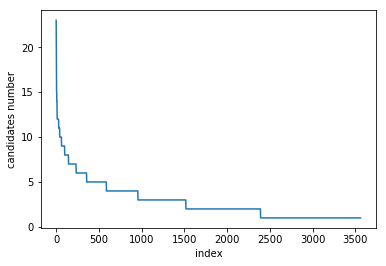

In [313]:
# 0.9/50
confu_raw = create(dataset)
info(confu_raw)

Total_error: 3411
Sum_cands: 9054
Max_cands: 23
Min_cands: 1
Mean_cands: 2.65
Mid_cands: ('俱', 2)
Top 20 cands:
 [('是', 23), ('事', 21), ('以', 17), ('至', 15), ('起', 14), ('經', 14), ('之', 13), ('付', 13), ('識', 12), ('師', 12), ('心', 12), ('正', 12), ('式', 12), ('一', 12), ('長', 12), ('知', 12), ('息', 12), ('決', 12), ('時', 12), ('機', 12)]


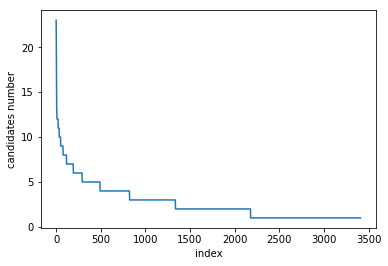

In [33]:
# 0.8/50
threshold = [0.8,50]
confu_raw = create(dataset)
info(confu_raw)

Total_error: 3607
Sum_cands: 10200
Max_cands: 23
Min_cands: 1
Mean_cands: 2.83
Mid_cands: ('窺', 2)
Top 20 cands:
 [('是', 23), ('事', 21), ('以', 17), ('昤', 16), ('貍', 15), ('鉋', 15), ('至', 15), ('隹', 14), ('鮫', 14), ('起', 14), ('經', 14), ('蝓', 13), ('之', 13), ('付', 13), ('氦', 12), ('識', 12), ('師', 12), ('心', 12), ('正', 12), ('鉑', 12)]


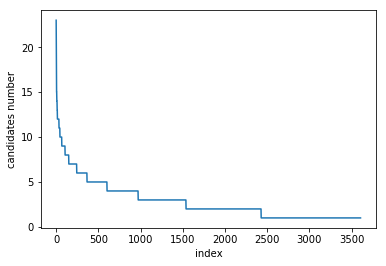

In [335]:
# 0.7/30
threshold = [0.7,30]
confu_raw = create(dataset)
info(confu_raw)

Total_error: 3643
Sum_cands: 10302
Max_cands: 23
Min_cands: 1
Mean_cands: 2.83
Mid_cands: ('匡', 2)
Top 20 cands:
 [('是', 23), ('事', 21), ('以', 17), ('昤', 16), ('貍', 15), ('鉋', 15), ('至', 15), ('隹', 14), ('鮫', 14), ('起', 14), ('經', 14), ('蝓', 13), ('之', 13), ('付', 13), ('鯖', 13), ('氦', 12), ('識', 12), ('師', 12), ('心', 12), ('正', 12)]


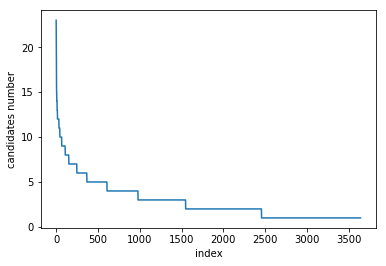

In [336]:
# 0.6/30
threshold = [0.6, 30]
confu_raw = create(dataset)
info(confu_raw)

In [311]:
confu_raw['鉑']

{'伯': 0.9999999999999699,
 '帕': 0.9437608408254147,
 '帛': 0.9999998776399319,
 '柏': 0.9999999999999699,
 '泊': 0.9999999999999699,
 '白': 1,
 '箔': 0.9974343539890578,
 '粕': 0.9999994837121372,
 '舶': 0.9999999999999699,
 '迫': 0.999988737048717,
 '鈸': 0.9999960053510258,
 '魄': 0.9316106477359433}

In [304]:
ch_x, ch_y = '世','紲'
t = dataset[ch_x][ch_y][1][:-2]
t.append(dataset[ch_x][ch_y][0])

print(t)

ffff = fCombine(dataset[ch_x][ch_y][0], dataset[ch_x][ch_y][1])

print(ffff)

# tmp = np.asarray(t).reshape(1,-1)
tmp = np.asarray(ffff).reshape(1,-1)

print(clf.classes_)
print(clf.predict(tmp))
clf.predict_proba(tmp).tolist()[0]


[4, 1, 1, 0, 1, 0, 0, -3.102533, -99.0, 0.0, 7.0]
[4, 1, 1, 0, 1, 0, 0, -3.102533, -99.0, 0.0, 7.0]
[-1  1]
[1]


[3.00000089999998e-14, 0.9999999999999699]

In [256]:
clf.classes_

array([-1,  1])

In [246]:
t

[4,
 0,
 0,
 4,
 0,
 0,
 3.0,
 -4.646023,
 -2.961896,
 0.088673893414276256,
 11.886738934142763]

In [248]:
t

[3,
 0,
 0,
 3,
 0,
 0,
 3.0,
 -4.646023,
 -2.911803,
 0.12919455018158885,
 10.291945501815889]

In [243]:
clf.predict(np.asarray(t).reshape(1,-1))

array([1])

In [329]:
confu = outputPKL(confu_raw, 0.999995, output_file('999995_9_50'))

In [34]:
confu = outputPKL(confu_raw, 0.9999995, output_file('9999995_8_50'))

In [333]:
confu = outputPKL(confu_raw, 0.995, output_file('995_9_50'))

In [334]:
confu['方']

{'房': 0.00492610837438424,
 '放': 0.00492610837438424,
 '方': 0.980295566502463,
 '芳': 0.00492610837438424,
 '風': 0.00492610837438424}

In [317]:
confu_raw['方']

{'房': 1, '放': 1, '芳': 1, '風': 1}